In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import IPython
from mpl_toolkits.axes_grid1 import make_axes_locatable
from misc import reportProgress
from scipy.ndimage.filters import gaussian_filter
from misc import round_sig_str as round_sig_str
import misc
from GaussianFilter import gaussianFilter

In [2]:
avgPhotonsPerImage = 50
QE = 0.9
darkElectronChance = 0.0003
seed = random.randint(1,70)
rs = np.random.RandomState(seed)
size = 10
#center of array
p0=int(size/2)
h_pixelsInBin = 2
v_pixelsInBin = 2
minBlur = 1
fovSize = 10


In [3]:
def reportProgress(num, total):
    print( round_sig_str(num/total*100) + '%                     ',  end='\r' )
    IPython.display.clear_output(wait=True)

In [4]:
def gaus(x, m, s):
    return (1/(s*np.sqrt(2*np.pi))*np.exp(-(x-m)**2/(2*s**2)))                            

xx, yy, zz = np.meshgrid(np.arange(size), np.arange(size), np.arange(size))
gaus3d = avgPhotonsPerImage*gaus(xx, p0, 2)*gaus(yy, p0, 2)*gaus(zz, p0, 2)

In [5]:
def slicer(input3D):
    
    all2DSlices = [input3D[i] for i in range(0,size)]
    blurrySlices=[]

    for j in range(0,len(all2DSlices)):
        blurrySlice = gaussianFilter(all2DSlices[j], size, p0, minBlur, fovSize)
        blurrySlices.append(blurrySlice)

    blurrySlicesAvg = sum(blurrySlices)/len(blurrySlices)
    
    return blurrySlicesAvg

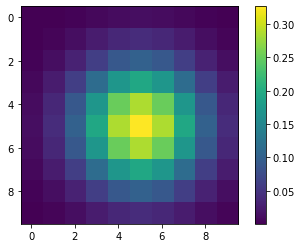

In [22]:
blurredPhotonImage = slicer(gaus3d)
plt.imshow(blurredPhotonImage)
plt.colorbar()

In [21]:
image = np.zeros((size, size))
for rowi, row in enumerate(blurredPhotonImage):
    for coli, col in enumerate(row):
        meanIntensity = blurredPhotonImage[rowi, coli]
        #print(meanIntensity)

In [8]:
x = np.arange(1000)

def gain(x): 
    return np.exp(-0.009*x)

gain_pdf=gain(x)

#print(np.random.choice(x, p=gain_pdf/sum(gain_pdf)))

In [9]:
def bins(originalImage, pixelsInBin):
    binned = []
    for rowi, row in enumerate(originalImage):
        for coli in range(0, len(row), pixelsInBin):
            binned.append(singleBinH(originalImage, rowi, coli, pixelsInBin))
        

    floats = [float(m) for m in binned]
    binning = np.reshape(floats, (originalImage.shape[0],int(originalImage.shape[1]/pixelsInBin))) 
    
    return binning

In [10]:
def bin2D(originalImage, hPixelsInBin, vPixelsInBin):
    
    #12x15
    #hbinning=3, vbinning = 4
    #result: 3x5
    
    hBinnedImage = bins(originalImage, hPixelsInBin)
    #print(hBinnedImage.shape, 'h')
    #12x5
    transposed = np.array(misc.transpose(hBinnedImage))
    #print(transposed.shape, 't')
    #5x12
    vBinnedImage = bins(transposed, vPixelsInBin)
    #print(vBinnedImage.shape, 'v')
    #5x3
    bothBinned = np.array(misc.transpose(vBinnedImage))
    #print(bothBinned.shape, 'f')
    
    return bothBinned 

In [11]:
def singleBinH(originalImage, rowi, coli, pixelsInBin): 
    return sum(originalImage[rowi, coli:coli+pixelsInBin])

In [18]:
def getSimulatedImage():
    
    
    image = np.zeros((size, size))
    photonImage = np.zeros((size, size))
    blurred = np.zeros((size,size))
    newImage = np.zeros((int(size/h_pixelsInBin), int(size/v_pixelsInBin)))
            
    #This loop applies Poisson-distributed shotnoise.        
    for rowi, row in enumerate(image):
        for coli, col in enumerate(row):
            #sample from blurred gaussian
            print(blurredPhotonImage.shape)
            meanIntensity = blurredPhotonImage[rowi, coli]
            shotnoise = rs.poisson(meanIntensity)
            photonImage[rowi, coli] += shotnoise
            
    #Calculate number of electrons accounting for QE, dark electrons, EM gain noise, and readout noise.
    for rowi, row in enumerate(image):
        for coli, col in enumerate(row):
            numPhotons = photonImage[rowi, coli]
            numElectrons = numPhotons*QE
            #random chance to find a "Dark electron"           
            if np.random.random() < darkElectronChance:
                numElectrons += 1    
                
           # photonImage[rowi, coli] +=numElectrons
                
 
        #EM gain amplification: using 1 distribution, sampling from it as many times as there are electrons on a pixel.
            if numElectrons == 0:
                electronsGained = 0
            elif numElectrons == 1:
                ElectronsOut = np.random.choice(x, p=gain_pdf/sum(gain_pdf))
                electronsGained = ElectronsOut
            else:
                ElectronsOut = np.random.choice(x, size=int(numElectrons), p=gain_pdf/sum(gain_pdf))
                electronsGained = sum(ElectronsOut)
            photonImage[rowi, coli] += electronsGained
            previousNoise = photonImage[rowi, coli]
 #camera binning in 2D
    h_v_binned = bin2D(photonImage, h_pixelsInBin, v_pixelsInBin)   
    for rowi, row in enumerate(h_v_binned):
        for coli, col in enumerate(row):   
            
            readOutNoise = np.random.randint(0, 20)
            #counts = readOutNoise

            h_v_binned[rowi, coli] += readOutNoise
            
    return h_v_binned

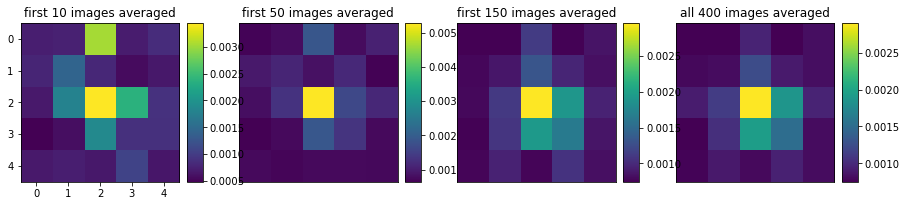

In [19]:
imageSeries = []

for imageNum in range(300):
    imageSeries.append(getSimulatedImage())
    reportProgress(imageNum, 300)

avgImage3 = np.mean(imageSeries [:10], 0)
avgImage25 = np.mean(imageSeries [:50], 0)
avgImage50 = np.mean(imageSeries [:170], 0)
avgImage = np.mean(imageSeries,0)


normalizedImage3 = avgImage3/(111**2)
normalizedImage25 = avgImage25/(111**2)
normalizedImage50 = avgImage50/(111**2)
normalizedImage = avgImage/(111**2)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=[15, 15])

img0 = ax0.imshow(normalizedImage3)
ax0.set_title('first 10 images averaged')

divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="10%", pad=0.10)
cb0 = plt.colorbar(img0, cax=cax)

img1 = ax1.imshow(normalizedImage25)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('first 50 images averaged')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="10%", pad=0.10)
cb = plt.colorbar(img1, cax=cax)

img2 = ax2.imshow(normalizedImage50)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('first 150 images averaged')

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="10%", pad=0.10)
cb = plt.colorbar(img2, cax=cax)

img3 = ax3.imshow(normalizedImage)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('all 400 images averaged')

divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="10%", pad=0.10)
cb = plt.colorbar(img3, cax=cax)

plt.show()
